# 0. Imports

In [23]:
# pip freeze > requirements.txt

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import os


torch.manual_seed(1)         # PyTorch CPU
torch.cuda.manual_seed(1)    # PyTorch GPU


# 1. Training Data

In [11]:
# -------------------------
# 1. Preparar dados
# -------------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),          # corta e desloca a imagem aleatoriamente
    transforms.RandomHorizontalFlip(),             # espelha horizontalmente
    transforms.RandomRotation(15),                 # rotaciona até ±15 graus
    transforms.ColorJitter(
        brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1
    ),                                             # muda cores
    transforms.RandomAffine(
        degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10
    ),                                             # distorce, translada, escala e inclina
    transforms.ToTensor(),                          # converte para tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normaliza
])


if os.path.exists("./00_TrainingData"):
    trainset = torchvision.datasets.CIFAR10(root='./00_TrainingData', train=True,
                                            download=False, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                            shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./00_TrainingData', train=False,
                                        download=False, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                            shuffle=False)
else:
    trainset = torchvision.datasets.CIFAR10(root='./00_TrainingData', train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                            shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./00_TrainingData', train=False,
                                        download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                            shuffle=False)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 2. CNN Architecture

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()
        stride = 2 if downsample else 1
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Ajuste da dimensão do atalho (skip connection) se necessário
        self.shortcut = nn.Sequential()
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # skip connection
        return F.relu(out)


class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        
        # Bloco inicial
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Blocos ResNet-like
        self.layer1 = ResidualBlock(64, 64)
        self.layer2 = ResidualBlock(64, 128, downsample=True)   # reduz dimensão
        self.layer3 = ResidualBlock(128, 256, downsample=True)  # mais profundo
        self.layer4 = ResidualBlock(256, 512, downsample=True)  # mais profundo
        
        # Adaptive pooling → sempre gera 1x1 independente da entrada
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classificador
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)  # (batch, 512)
        out = self.fc(out)
        return out
    
    
net = CNN().to(device)

# 3. CNN Training

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# -------------------------
# 4. Treinamento
# -------------------------
num_epochs = 50

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    scheduler.step()
    train_loss = running_loss / len(trainloader.dataset)
    train_acc = 100. * correct / total
    
    # Avaliação no teste
    net.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_acc = 100. * correct_test / total_test
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


Epoch 1/50 | Loss: 1.6419 | Train Acc: 39.84% | Test Acc: 52.56%
Epoch 2/50 | Loss: 1.2381 | Train Acc: 55.55% | Test Acc: 63.07%
Epoch 3/50 | Loss: 1.0678 | Train Acc: 62.05% | Test Acc: 63.92%
Epoch 4/50 | Loss: 0.9501 | Train Acc: 66.46% | Test Acc: 70.22%
Epoch 5/50 | Loss: 0.8530 | Train Acc: 70.06% | Test Acc: 70.70%
Epoch 6/50 | Loss: 0.7891 | Train Acc: 72.28% | Test Acc: 74.85%
Epoch 7/50 | Loss: 0.7339 | Train Acc: 74.35% | Test Acc: 76.83%
Epoch 8/50 | Loss: 0.6866 | Train Acc: 76.10% | Test Acc: 79.37%
Epoch 9/50 | Loss: 0.6458 | Train Acc: 77.38% | Test Acc: 79.87%
Epoch 10/50 | Loss: 0.6204 | Train Acc: 78.27% | Test Acc: 80.89%
Epoch 11/50 | Loss: 0.5946 | Train Acc: 79.23% | Test Acc: 81.86%
Epoch 12/50 | Loss: 0.5665 | Train Acc: 80.34% | Test Acc: 81.98%
Epoch 13/50 | Loss: 0.5474 | Train Acc: 80.95% | Test Acc: 81.78%
Epoch 14/50 | Loss: 0.5264 | Train Acc: 81.84% | Test Acc: 83.45%
Epoch 15/50 | Loss: 0.5018 | Train Acc: 82.59% | Test Acc: 85.56%
Epoch 16/50 | Loss:

# 4. Testing with new data

In [20]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Transformações iguais às usadas no treino
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # CIFAR-10 tem 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Carregar a imagem
img = Image.open("./01_TestingDataFromInternet/dog.jpg").convert("RGB")

# Aplicar as transformações
img_tensor = transform(img)

# Adicionar dimensão de batch [1, 3, 32, 32]
img_tensor = img_tensor.unsqueeze(0)


In [21]:
net.eval()  # modo de avaliação
with torch.no_grad():
    img_tensor = img_tensor.to(device)
    outputs = net(img_tensor)
    _, predicted = torch.max(outputs, 1)

print("Classe prevista:", classes[predicted.item()])


Classe prevista: dog


# 5. Save the model

In [ ]:
torch.save(net.state_dict(), os.path.dirname(os.getcwd())+"\\01_ModelDeployment\\model\\CNN_Model.pth")


# 6. Heatmap

In [3]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [4]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hook para capturar gradientes e ativações
        def forward_hook(module, input, output):
            self.activations = output.detach()
            
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
            
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
    
    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        self.model.zero_grad()
        output[0, class_idx].backward()
        
        gradients = self.gradients
        activations = self.activations
        
        # Calcula pesos médios por canal
        weights = gradients.mean(dim=(2, 3), keepdim=True)
        
        # Combina canais ponderados
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        
        # Normaliza para [0,1]
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.squeeze().cpu().numpy()
        
        return cam


In [19]:
# Caminho da imagem
img_path = "./01_TestingDataFromInternet/cavalo.jpg"

# Transformações
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

img = Image.open(img_path).convert('RGB')
input_tensor = transform(img).unsqueeze(0)  # batch size 1


In [ ]:
model = CNN(num_classes=10)
# model.load_state_dict(torch.load(os.path.dirname(os.path.join(os.getcwd())),"01_ModelDeployment/model", "CNN_Model.pth"), map_location=torch.device(device))

model.eval()

# Supondo que você quer ver a atenção da última camada convolucional (layer4)
target_layer = model.layer4

gradcam = GradCAM(model, target_layer)
heatmap = gradcam.generate(input_tensor)


AttributeError: 'str' object has no attribute '__name__'

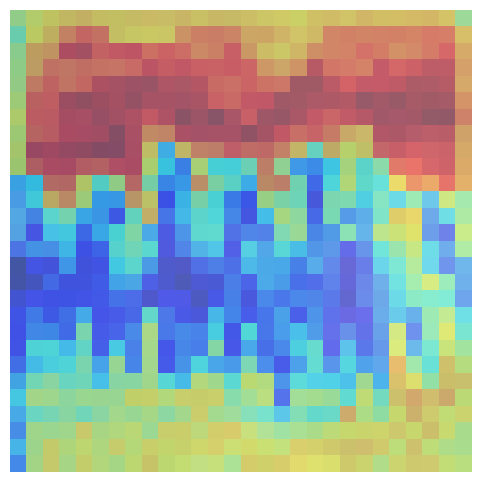

In [21]:
# Converte imagem original para numpy
img_np = np.array(img.resize((224, 224))) / 255.0

# Redimensiona heatmap
heatmap_resized = np.uint8(255 * heatmap)
heatmap_resized = np.stack([heatmap_resized]*3, axis=2)

# Cria overlay
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()


In [ ]:
# Converte imagem original para numpy
img_np = np.array(img.resize((224, 224))) / 255.0

# Redimensiona heatmap
heatmap_resized = np.uint8(255 * heatmap)
heatmap_resized = np.stack([heatmap_resized]*3, axis=2)

# Cria overlay
plt.figure(figsize=(6, 6))
plt.imshow(img_np)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')
plt.show()
